In [1]:
versioninfo()

Julia Version 1.10.2
Commit bd47eca2c8a (2024-03-01 10:14 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 32 × Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, haswell)
Threads: 1 default, 0 interactive, 1 GC (on 32 virtual cores)
Environment:
  JULIA_PKG_SERVER = https://mirrors.tuna.tsinghua.edu.cn/julia


- https://turinglang.org/dev/tutorials/01-gaussian-mixture-model/

- \mu(tab)\_k(tab)  to type $\mu_k$
- FillArrays.Fill() or Eye() etc. enables a lazy representation of matrix.

In [2]:
# set the output format of gr backend to png. default is svg, which maldisplays in jupyter pages (after restart).
# StatsPlots has an identical gr() function.
@time using Plots;
#gr(fmt = "png")
@time gr(fmt = :png)

@time using StatsPlots; 
@time gr(fmt = :png)

  2.449027 seconds (1.52 M allocations: 102.434 MiB, 6.39% gc time, 11.31% compilation time: 88% of which was recompilation)
  0.000049 seconds (5 allocations: 576 bytes)
  1.257957 seconds (753.10 k allocations: 39.206 MiB, 1.81% compilation time: 100% of which was recompilation)
  0.000039 seconds (5 allocations: 576 bytes)


Plots.GRBackend()

In [3]:
using Distributions
using FillArrays
using StatsPlots

using LinearAlgebra
using Random

# Set a random seed.
Random.seed!(3)

# Define Gaussian mixture model.
w = [0.5, 0.5]
μ = [-3.5, 0.5]
mixturemodel = MixtureModel([MvNormal(Fill(μₖ, 2), Distributions.I) for μₖ in μ], w)

# We draw the data points.
N = 60
x = rand(mixturemodel, N);

LoadError: ArgumentError: Package FillArrays not found in current path.
- Run `import Pkg; Pkg.add("FillArrays")` to install the FillArrays package.

In [4]:
?Distributions.I

```
I
```

An object of type [`UniformScaling`](@ref), representing an identity matrix of any size.

# Examples

```jldoctest
julia> fill(1, (5,6)) * I == fill(1, (5,6))
true

julia> [1 2im 3; 1im 2 3] * I
2×3 Matrix{Complex{Int64}}:
 1+0im  0+2im  3+0im
 0+1im  2+0im  3+0im
```


In [5]:
@show Fill(3,2)

Fill(3, 2) = Fill(3, 2)


2-element Fill{Int64}, with entries equal to 3

In [6]:
?MixtureModel

search: MixtureModel mixturemodel AbstractMixtureModel



MixtureModel{VF<:VariateForm,VS<:ValueSupport,C<:Distribution,CT<:Real} A mixture of distributions, parametrized on:

  * `VF,VS` variate and support
  * `C` distribution family of the mixture
  * `CT` the type for probabilities of the prior

---

```
MixtureModel(components, [prior])
```

Construct a mixture model with a vector of `components` and a `prior` probability vector. If no `prior` is provided then all components will have the same prior probabilities.

---

```
MixtureModel(C, params, [prior])
```

Construct a mixture model with component type $C$, a vector of parameters for constructing the components given by $params$, and a prior probability vector. If no `prior` is provided then all components will have the same prior probabilities.


In [7]:
?MvNormal

search: MvNormal MvNormalCanon MvNormalKnownCov MvLogNormal AbstractMvNormal



```
MvNormal
```

Generally, users don't have to worry about these internal details.

We provide a common constructor `MvNormal`, which will construct a distribution of appropriate type depending on the input arguments.

---

```
MvNormal(μ::AbstractVector{<:Real}, Σ::AbstractMatrix{<:Real})
```

Construct a multivariate normal distribution with mean `μ` and covariance matrix `Σ`.

---

```
MvNormal(Σ::AbstractMatrix{<:Real})
```

Construct a multivariate normal distribution with zero mean and covariance matrix `Σ`.


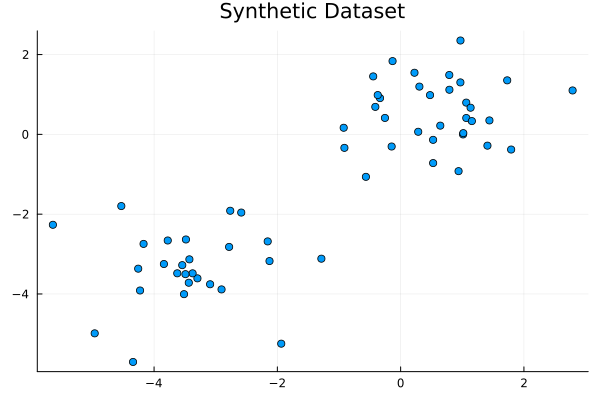

In [8]:
scatter(x[1, :], x[2, :]; legend=false, title="Synthetic Dataset")

In [9]:
using Turing

@model function gaussian_mixture_model(x)
    # Draw the parameters for each of the K=2 clusters from a standard normal distribution.
    K = 2
    μ ~ MvNormal(Zeros(K), I)

    # Draw the weights for the K clusters from a Dirichlet distribution with parameters αₖ = 1.
    w ~ Dirichlet(K, 1.0)
    # Alternatively, one could use a fixed set of weights.
    # w = fill(1/K, K)

    # Construct categorical distribution of assignments.
    distribution_assignments = Categorical(w)

    # Construct multivariate normal distributions of each cluster.
    D, N = size(x)
    distribution_clusters = [MvNormal(Fill(μₖ, D), I) for μₖ in μ]

    # Draw assignments for each datum and generate it from the multivariate normal distribution.
    k = Vector{Int}(undef, N)
    for i in 1:N
        k[i] ~ distribution_assignments
        x[:, i] ~ distribution_clusters[k[i]]
    end

    return k
end

model = gaussian_mixture_model(x);

In [10]:
?MCMCThreads

search: MCMCThreads



```
MCMCThreads
```

The `MCMCThreads` algorithm allows users to sample MCMC chains in parallel using multiple threads.


In [ ]:
sampler = Gibbs(PG(100, :k), HMC(0.05, 10, :μ, :w))
nsamples = 100
nchains = 3
@time chains = sample(model, sampler, MCMCThreads(), nsamples, nchains);

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC ~/.julia/packages/AbstractMCMC/fWWW0/src/sample.jl:296


In [ ]:
plot(chains[["μ[1]", "μ[2]"]]; colordim=:parameter, legend=true)

In [ ]:
chains